In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration

In [3]:
import os
path2train="/content/drive/MyDrive/Single-Object Segmentation using pytorch-20240610T161807Z-001/Single-Object Segmentation using pytorch/training_set"

imgsList=[pp for pp in os.listdir(path2train) if "Annotation" not in pp]
anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 999
number of annotations: 999


In [4]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['84_HC.png', '396_HC.png', '176_HC.png', '844_HC.png'],
      dtype='<U11')

In [5]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)

    img_mask=mark_boundaries(np.array(img),
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

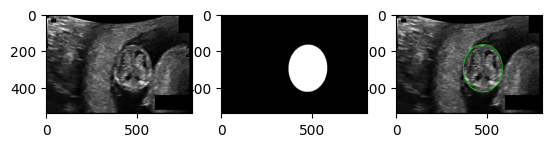

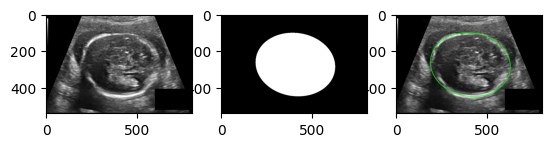

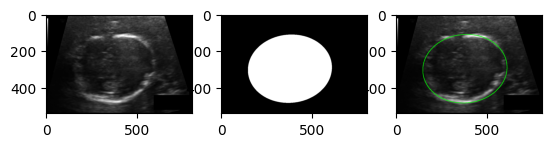

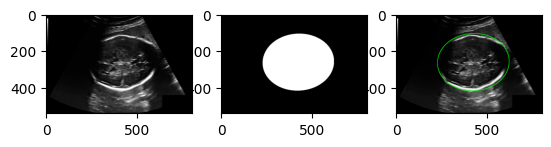

In [6]:

for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask)

(-0.5, 799.5, 539.5, -0.5)

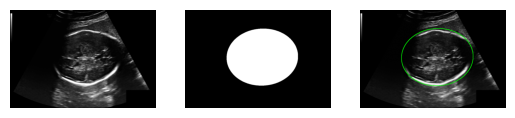

In [7]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
show_img_mask(img, mask)
plt.axis('off')

In [8]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    Resize,
)

h,w=128,192
transform_train = Compose([ Resize(h,w),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
              ])


transform_val = Resize(h,w)

# Creating Custom Dataset

In [9]:
from torch.utils.data import Dataset
from PIL import Image

In [10]:
from torchvision.transforms.functional import to_tensor, to_pil_image

class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):

        imgsList=[pp for pp in os.listdir(path2data) if "Annotation" not in pp]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]

        self.transform = transform

    def __len__(self):
        return len(self.path2imgs)

    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)

        image= np.array(image)
        mask=mask.astype("uint8")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image= to_tensor(image)
        mask=255*to_tensor(mask)
        return image, mask


In [11]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [12]:

img, mask = fetal_ds1[0]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))


torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


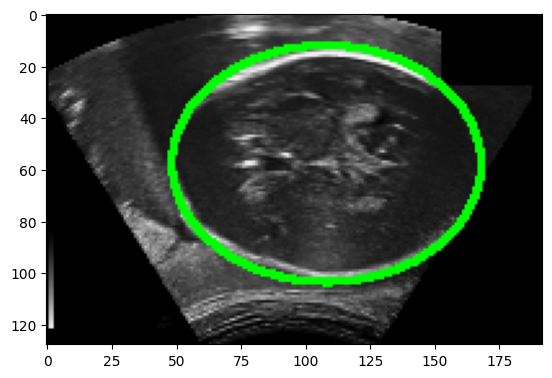

In [13]:
show_img_mask(img, mask)

## Split data into train validation

In [14]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [15]:
from torch.utils.data import Subset

train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

799
200


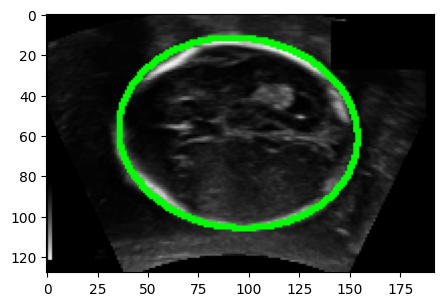

In [16]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img,mask)
    break

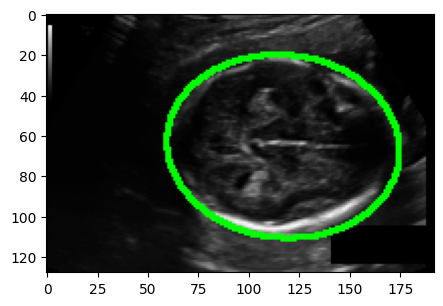

In [17]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img,mask)
    break

## Creating DataLoader

In [18]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [19]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [20]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


In [21]:
torch.max(img_b)

tensor(0.9961)

# Creating the Model

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()

        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_outputs=params["num_outputs"]

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))

        x = self.conv_out(x)

        return x

In [24]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16,
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [25]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [26]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [27]:
from torchsummary import summary
summary(model, input_size=(1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

# Define Loss Function

In [28]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3))

    dice= 2.0 * (intersection + smooth) / (union+ smooth)
    loss = 1.0 - dice

    return loss.sum(), dice.sum()


In [29]:

import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')

    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)

    loss = bce  + dlv

    return loss

In [30]:
for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break



print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))

(tensor(0.), tensor(8.))


tensor(173975.0156)

In [31]:
import torchvision

def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)

    return metric

In [32]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)

    with torch.no_grad():
        pred= torch.sigmoid(output)
        _, metric_b=dice_loss(pred, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Optimizer

In [33]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [35]:

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


# Training the Model

In [36]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)

        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)

    metric=running_metric/float(len_data)

    return loss, metric

In [37]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": []}

    metric_history={
        "train": [],
        "val": []}


    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("-"*10)


    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history


In [38]:
opt = optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 11974.645895, dice: 42.01
val loss: 7934.102383, dice: 55.95
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 6384.514596, dice: 69.11
val loss: 5188.711055, dice: 78.59
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 5060.444753, dice: 75.49
val loss: 4495.960586, dice: 77.34
----------
Epoch 3/99, current lr=0.0003
train loss: 4255.353068, dice: 78.97
val loss: 4601.077090, dice: 75.80
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 3823.848881, dice: 80.63
val loss: 3544.702266, dice: 84.22
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 3220.239090, dice: 83.61
val loss: 3164.358203, dice: 84.61
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 2967.177277, dice: 84.76
val loss: 3078.909502, dice: 85.51
----------
Epoch 7/99, current lr=0.0003
Copied best mode

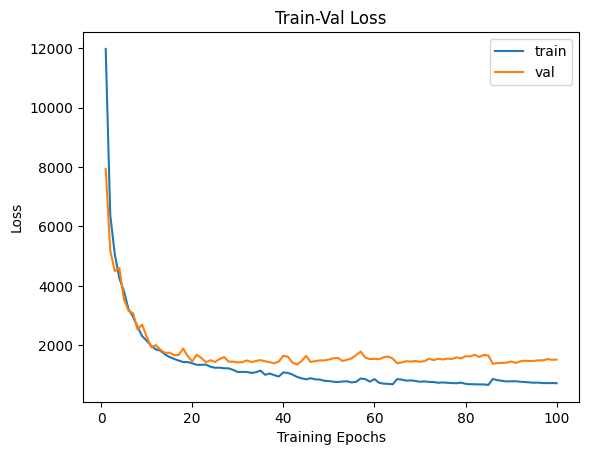

In [39]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

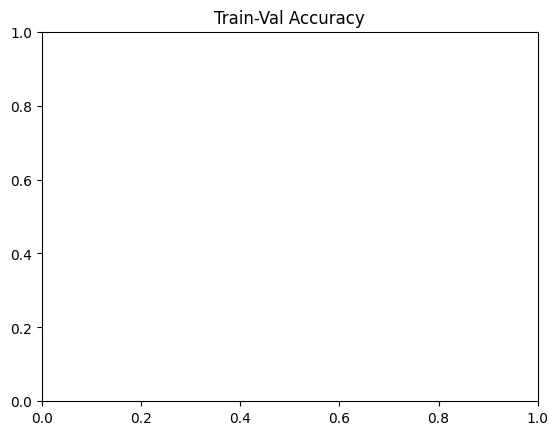

In [40]:
# plot accuracy progress
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

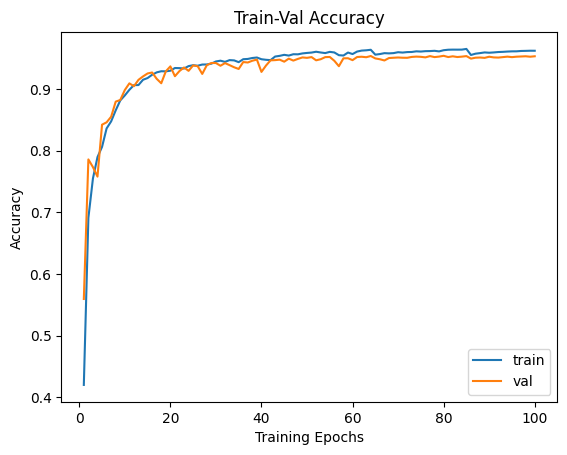

In [41]:
# plot accuracy progress
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),[x.cpu() for x in metric_hist["train"]],label="train") # Move tensors to CPU
plt.plot(range(1,num_epochs+1),[x.cpu() for x in metric_hist["val"]],label="val") # Move tensors to CPU
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Deployment

## Data Exploration

In [43]:
import os
path2test="/content/drive/MyDrive/Single-Object Segmentation using pytorch-20240610T161807Z-001/Single-Object Segmentation using pytorch/test_set"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp]
print("number of images:", len(imgsList))


number of images: 335


In [44]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['217_2HC.png', '322_HC.png', '193_HC.png', '105_3HC.png'],
      dtype='<U11')

## Creating the model

In [45]:
import torch.nn as nn
import torch.nn.functional as F

In [46]:

class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()

        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_outputs=params["num_outputs"]

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))

        x = self.conv_out(x)

        return x

In [47]:
h,w=128,192
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16,
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [48]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [49]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

def show_img_mask(img, mask):

    img_mask=mark_boundaries(np.array(img),
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

In [50]:
path2weights="./models/weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Error: Image file not found: /content/drive/MyDrive/Single-Object Segmentation using pytorch-20240610T161807Z-001/Single-Object Segmentation using pytorch/training_set/217_2HC.png
Error: Image file not found: /content/drive/MyDrive/Single-Object Segmentation using pytorch-20240610T161807Z-001/Single-Object Segmentation using pytorch/training_set/105_3HC.png


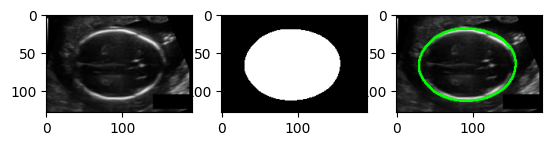

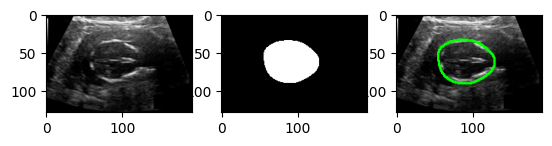

In [53]:
from torchvision.transforms.functional import to_tensor, to_pil_image

# Verify the path to your training set
path2train = "/content/drive/MyDrive/Single-Object Segmentation using pytorch-20240610T161807Z-001/Single-Object Segmentation using pytorch/training_set/"

# Check if the directory exists
if not os.path.exists(path2train):
    print("Error: Training set directory not found.")
else:
    for fn in rndImgs:
        path2img = os.path.join(path2train, fn)

        # Check if the image file exists
        if not os.path.exists(path2img):
            print(f"Error: Image file not found: {path2img}")
            continue  # Skip to the next image

        img = Image.open(path2img)
        img = img.resize((w, h))
        img_t = to_tensor(img).unsqueeze(0).to(device)

        pred = model(img_t)
        pred = torch.sigmoid(pred)[0]
        mask_pred = (pred[0] >= 0.5)

        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap="gray")

        plt.subplot(1, 3, 2)
        # Move the tensor to CPU before converting to NumPy array
        plt.imshow(mask_pred.cpu().numpy(), cmap="gray")

        plt.subplot(1, 3, 3)
        show_img_mask(img, mask_pred.cpu().numpy()) # Also move the mask here